# Malaria Detection from Cell Images

Dataset link: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

Same or similar datasets can be obtained from the official [NIH Website](https://ceb.nlm.nih.gov/repositories/malaria-datasets/)

The dataset contains 2 folders

1. Parasitized
2. Uninfected

And a total of `27,558` images.

In [1]:
#  install opendatasets and splitfolders, if not installed already
!pip install opendatasets
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
# import required libraries
import numpy as np
import pandas as pd
import opendatasets as od
import splitfolders
import itertools
import base64
import io, os, signal
import shutil
from shutil import copy
from shutil import copytree, rmtree
import matplotlib.pyplot as plt
% matplotlib inline
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from tensorflow.keras.preprocessing import image

In [3]:
# Check Tensorflow and Keras version; check if GPU is available
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensorflow version: 2.8.2
Keras version: 2.8.0
GPU is available


In [4]:
# set seed
tf.random.set_seed(1)

In [5]:
# download the dataset
od.download("https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria")

100%|██████████| 675M/675M [00:13<00:00, 51.2MB/s]


In [6]:
# create dataset folder and set folder variables
dir = 'dataset'
parent_dir = './cell-images-for-detecting-malaria'
path = os.path.join(parent_dir, dir)
os.mkdir(path)

base_dir = './cell-images-for-detecting-malaria/cell_images/cell_images/'
dataset_dir = './cell-images-for-detecting-malaria/dataset/'

In [7]:
# split data into train, val and test
input_folder = base_dir
output = dataset_dir
splitfolders.ratio(input_folder, output=output, 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None)

Copying files: 27560 files [00:04, 6864.55 files/s]


In [8]:
# Check the dataset folder
!ls ./cell-images-for-detecting-malaria/dataset/

test  train  val


In [9]:
# cleanup
if os.path.exists('./cell-images-for-detecting-malaria/cell_images'):
    shutil.rmtree('./cell-images-for-detecting-malaria/cell_images')

## EDA

In [10]:
# Number of images in each class in 'train', 'val' and 'test

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')
class_names = os.listdir(train_dir)

print('Number of cell image classes in train:', len(os.listdir(train_dir)))
print(os.listdir(train_dir))
for cls in os.listdir(train_dir):
    print(cls, ':', len(os.listdir(train_dir + '/' + cls)))


print('\nNumber of cell image classes in val:', len(os.listdir(val_dir)))
print(os.listdir(val_dir))
for cls in os.listdir(val_dir):
    print(cls, ':', len(os.listdir(val_dir + '/' + cls)))


print('\nNumber of cell image classes in test:', len(os.listdir(test_dir)))
print(os.listdir(test_dir))
for cls in os.listdir(test_dir):
    print(cls, ':', len(os.listdir(test_dir + '/' + cls)))

print('\nClass names:', class_names)

Number of cell image classes in train: 2
['Uninfected', 'Parasitized']
Uninfected : 9646
Parasitized : 9646

Number of cell image classes in val: 2
['Uninfected', 'Parasitized']
Uninfected : 2756
Parasitized : 2756

Number of cell image classes in test: 2
['Uninfected', 'Parasitized']
Uninfected : 1378
Parasitized : 1378

Class names: ['Uninfected', 'Parasitized']


In [11]:
# let's see what the filenames look like
print(os.listdir(train_dir + '/' + 'Parasitized')[:5])
print(os.listdir(train_dir + '/' + 'Uninfected')[:5])

['C111P72ThinF_IMG_20150930_113049_cell_164.png', 'C129P90ThinF_IMG_20151004_134306_cell_141.png', 'C48P9thinF_IMG_20150721_163810_cell_8.png', 'C68P29N_ThinF_IMG_20150819_133236_cell_164.png', 'C46P7ThinF_IMG_20151130_205828_cell_149.png']
['C220ThinF_IMG_20151106_154339_cell_170.png', 'C134P95ThinF_IMG_20151005_122331_cell_19.png', 'C144P105ThinF_IMG_20151015_155004_cell_24.png', 'C215ThinF_IMG_20151106_133643_cell_98.png', 'C219ThinF_IMG_20151106_145927_cell_92.png']


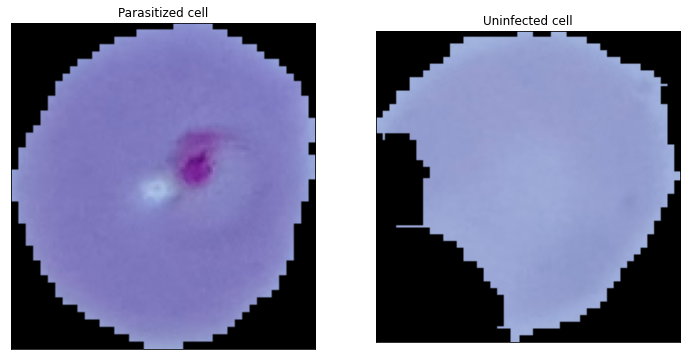

In [12]:
# Visualize one image from each class - 'Parasitized' and 'Uninfected'
ppic = './cell-images-for-detecting-malaria/dataset/train/Parasitized/C57P18thinF_IMG_20150729_111518_cell_253.png'
upic = './cell-images-for-detecting-malaria/dataset/train/Uninfected/C138P99ThinF_IMG_20151005_173241_cell_54.png'

plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(ppic))
plt.title("Parasitized cell")
plt.xticks([]) , plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(upic))
plt.title('Uninfected cell')
plt.xticks([]) , plt.yticks([])

plt.show()

## Data preprocessing

In [13]:
# Parameters for the loader
batch_size = 32
img_height = 128
img_width = 128
seed = 123
class_mode = 'binary'
color_mode = 'rgb'

# All images will be rescaled by 1./255 + image augmentation
train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
    )

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Flow training images in batches using train_datagen generator
train_ds = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(img_height, img_width),  # All images will be resized
        batch_size=batch_size,
        shuffle=True,
        class_mode=class_mode,
        color_mode=color_mode
    )

# Flow val images in batches using val_datagen generator
val_ds = val_datagen.flow_from_directory(
        val_dir,  # This is the source directory for training images
        target_size=(img_height, img_width),  # All images will be resized
        batch_size=batch_size,
        shuffle=True,
        class_mode=class_mode,
        color_mode=color_mode
    )

# Flow test images in batches using test_datagen generator
test_ds = test_datagen.flow_from_directory(
        test_dir,  # This is the source directory for training images
        target_size=(img_height, img_width),  # All images will be resized
        batch_size=batch_size,
        shuffle=False,
        class_mode=class_mode,
        color_mode=color_mode
    )

Found 19290 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [14]:
# Let's look at 1 of the the batches
train_batch = train_ds[0]
images, labels = list(train_batch)
print(images.shape)
print(labels.shape)

first_image = images[0]
first_image

# val_batch = val_ds[0]
# print(val_batch[0].shape)
# print(val_batch[1])
# test_batch = test_ds[0]
# print(test_batch[0].shape)
# print(test_batch[1])

(32, 128, 128, 3)
(32,)


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [15]:
first_image[:3, :3, 0]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

## Build model

In [16]:
# CNN model with dropout layer
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
                           input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

## Training

In [19]:
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

# Fit the model
history = model.fit(
      train_ds,
      steps_per_epoch=600,  # Total train images = batch_size * steps
      epochs=30,
      validation_data=val_ds,
      validation_steps=170,  # Total val images = batch_size * steps
      callbacks=[early_stopping],
      verbose=2)

Epoch 1/30
600/600 - 103s - loss: 0.4518 - accuracy: 0.7799 - val_loss: 0.1972 - val_accuracy: 0.9392 - 103s/epoch - 172ms/step
Epoch 2/30
600/600 - 95s - loss: 0.2646 - accuracy: 0.9029 - val_loss: 0.1636 - val_accuracy: 0.9557 - 95s/epoch - 158ms/step
Epoch 3/30
600/600 - 91s - loss: 0.2433 - accuracy: 0.9137 - val_loss: 0.1421 - val_accuracy: 0.9592 - 91s/epoch - 151ms/step
Epoch 4/30
600/600 - 89s - loss: 0.2338 - accuracy: 0.9174 - val_loss: 0.1647 - val_accuracy: 0.9548 - 89s/epoch - 148ms/step
Epoch 5/30
600/600 - 90s - loss: 0.2235 - accuracy: 0.9211 - val_loss: 0.1407 - val_accuracy: 0.9586 - 90s/epoch - 149ms/step
Epoch 6/30
600/600 - 94s - loss: 0.2140 - accuracy: 0.9267 - val_loss: 0.1326 - val_accuracy: 0.9599 - 94s/epoch - 156ms/step
Epoch 7/30
600/600 - 94s - loss: 0.2065 - accuracy: 0.9272 - val_loss: 0.1251 - val_accuracy: 0.9592 - 94s/epoch - 157ms/step
Epoch 8/30
600/600 - 89s - loss: 0.1992 - accuracy: 0.9301 - val_loss: 0.1213 - val_accuracy: 0.9618 - 89s/epoch - 1

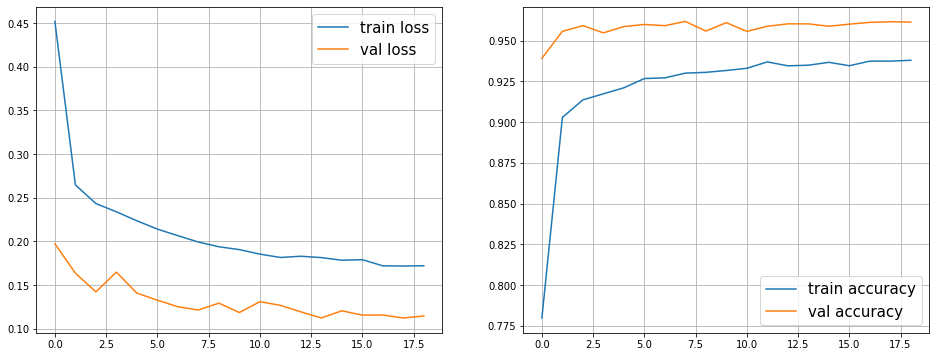

In [20]:
# plot loss and accuracy

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.grid()
plt.legend(fontsize=15)

In [21]:
# evaluate on test data
model.evaluate(test_ds, verbose=2)

87/87 - 3s - loss: 0.1299 - accuracy: 0.9536 - 3s/epoch - 37ms/step


[0.12988969683647156, 0.9535558819770813]

In [33]:
# save the model
model.save('./cell-images-for-detecting-malaria/malaria_detection_cnn_tf.h5')

In [32]:
# make some predictions
predictions = model.predict(test_ds)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_ds[60][1])
print(labels[:4])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0]


### Test predictions on cell images from internet

In [42]:
# Upload malaria images here and have it classified

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(128, 128))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is Unintefcted")
  else:
    print(fn + " is Parasitized")

Saving malaria-unintefcted-1.png to malaria-unintefcted-1 (3).png
Saving malaria-intefcted-1.jpeg to malaria-intefcted-1 (4).jpeg
[1.]
malaria-unintefcted-1.png is Unintefcted
[0.]
malaria-intefcted-1.jpeg is Parasitized


## Next steps:
1. Add visualizations for predictions
2. Use transfer learning and compare results